In [3]:
import pandas as pd
import re
import nltk
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from typing import List
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import gensim

In [8]:
dialogues = pd.read_csv('../code/emo_context_train.txt', sep="\t")
dialogues = dialogues[dialogues["label"]!="others"]
labels = dialogues.label
cols = ["turn1", "turn2", "turn3"]
dialogues["combined"] = dialogues[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
dialogues["combined"] = dialogues["combined"].apply(str.lower).apply(word_tokenize).apply(lambda x: " ".join(x))
dialogues["seq_len"] = dialogues["combined"].apply(len)

max_len = dialogues["seq_len"].max()
input_text = dialogues.combined.values

['when did i ? saw many times i think -_- no . i never saw you'
 'u r ridiculous i might be ridiculous but i am telling the truth . u little disgusting whore'
 'i hate my boyfriend you got a boyfriend ? yes' ...
 'shut up now getting mess up ? u cheated me'
 'waste yup , i said it , n0w what ? : p i blocked you bye waste'
 "i 'm not getting you 😭😭😭 why are you crying ? ? because you are not making any sense"]


In [5]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import math 
import sklearn
from sklearn import metrics

2023-04-27 15:37:26.261759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# split data into train and test and vectorise

In [6]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) 

In [7]:
w2v_vocab = word2vec_model.index_to_key
print(w2v_vocab[:10])
wv_dict={}
for word in w2v_vocab:
    wv_dict[word]= word2vec_model.get_vector(word)
print(len(wv_dict))

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']
3000000


In [17]:
max_review_len=-1
for i,rev in enumerate(input_text):
    tokens=rev.split()
    if(len(tokens)>max_review_len):
        max_review_len=len(tokens)
        
print(max_review_len)

80


In [20]:
X = input_text
tokenizer = Tokenizer(num_words=max_review_len, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim=300

pad_rev = pad_sequences(X, maxlen=max_review_len, padding='post')
pad_rev.shape 

(15212, 80)

In [21]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenizer.word_index.items():
    embed_vector=wv_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector

In [25]:
label_map = {'happy':0,'sad':1,'angry':2}
y = dialogues["label"].map(label_map)
y = np.asarray(y).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(pad_rev, y, test_size=0.2, random_state=16)

In [26]:
embed_dim = 128
lstm_out = 196
print(vocab_size)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length = max_review_len))
model.add(Dropout(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

10671
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 128)           1365888   
                                                                 
 dropout_1 (Dropout)         (None, 80, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 3)                 591       
                                                                 
Total params: 1,621,279
Trainable params: 1,621,279
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
batch_size = 64
model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=2)

Epoch 1/5
191/191 - 43s - loss: 1.0932 - accuracy: 0.3638 - 43s/epoch - 226ms/step
Epoch 2/5
191/191 - 43s - loss: 1.0930 - accuracy: 0.3629 - 43s/epoch - 225ms/step
Epoch 3/5
191/191 - 41s - loss: 1.0929 - accuracy: 0.3607 - 41s/epoch - 215ms/step
Epoch 4/5
191/191 - 42s - loss: 1.0927 - accuracy: 0.3534 - 42s/epoch - 221ms/step
Epoch 5/5
191/191 - 46s - loss: 1.0929 - accuracy: 0.3564 - 46s/epoch - 242ms/step


### Transform test data in the same way as train and make predictions

In [28]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

48/48 - 2s - loss: 1.0902 - accuracy: 0.3658 - 2s/epoch - 48ms/step
score: 1.09
acc: 0.37


### Compute the score and confusion matrix 

In [29]:
from sklearn.metrics import classification_report
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)

print("f1 score", sklearn.metrics.f1_score(y_test, y_prediction, average='macro'))

96/96 [==============================] - 2s 23ms/step
f1 score 0.17853705486044272


In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


labels = ['happy','angry','sad']
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_prediction)
display(confusion_matrix)
labels = [0,1,2]

array([[477, 195, 158],
       [167, 727, 219],
       [145, 301, 654]])

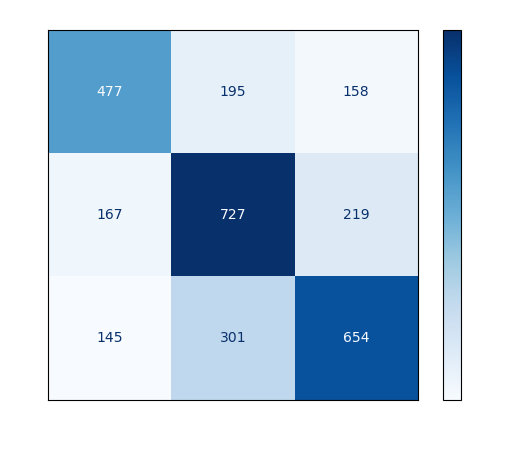

In [106]:
color = 'white'

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()